In [1]:
import os,sys
import numpy as np
import copy
import time
import h5py
import pandas as pd

codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import nsd_utils, default_paths, coco_utils
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
from model_fitting import initialize_fitting
from plotting_and_analysis import plot_utils 

Initializing coco api...
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=14.92s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
loading annotations into memory...
Done (t=14.01s)
creating index...
index created!


In [3]:
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info()

subject = 1;
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'LDA','S%d_LDA_animacy.npy'%subject)
# fn2load = os.path.join(default_paths.sketch_token_feat_path, 'LDA','S%d_LDA_all_supcat.npy'%subject)
pc_result = np.load(fn2load, allow_pickle=True).item()

scores_each_prf = pc_result['scores']
wts_each_prf = pc_result['wts']
trn_acc_each_prf = pc_result['trn_acc']
trn_dprime_each_prf = pc_result['trn_dprime']
val_acc_each_prf = pc_result['val_acc']
val_dprime_each_prf = pc_result['val_dprime']
labels_pred_each_prf = pc_result['labels_pred'];
labels_actual_each_prf = pc_result['labels_actual'];

n_images = len(labels_actual_each_prf[0])

In [4]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    
n_prfs = models.shape[0]

prf_model_index = 697
models[prf_model_index]

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


array([0.11      , 0.11      , 0.07722791])

In [5]:
ims_to_use = np.ones((n_images, ))==1
labels_actual = labels_actual_each_prf[prf_model_index][ims_to_use]
labels_pred = labels_pred_each_prf[prf_model_index][ims_to_use]

n_categ = len(np.unique(labels_actual))
# n_categ = len(supcat_names)
conf_mat = np.zeros(shape=(n_categ, n_categ))
for cc1 in range(n_categ):
    for cc2 in range(n_categ):
        
        conf_mat[cc1, cc2] = np.sum((labels_actual==cc1) & (labels_pred==cc2))

Text(0.5, 1.0, 'pRF 697')

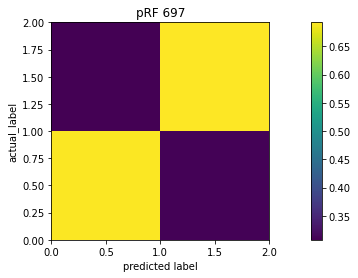

In [6]:
plt.figure();
conf_mat_norm = conf_mat/np.tile(np.sum(conf_mat, axis=1, keepdims=True), [1,n_categ])
plt.pcolormesh(conf_mat_norm)
plt.colorbar()
plt.xlabel('predicted label')
plt.ylabel('actual_label')
plt.axis('square')
# plt.gca().invert_yaxis()
plt.title('pRF %d'%prf_model_index)

In [15]:
scores.shape

(10000, 1)

Text(0.5, 0.98, 'pRF 697\nvalidation set dprime=1.02')

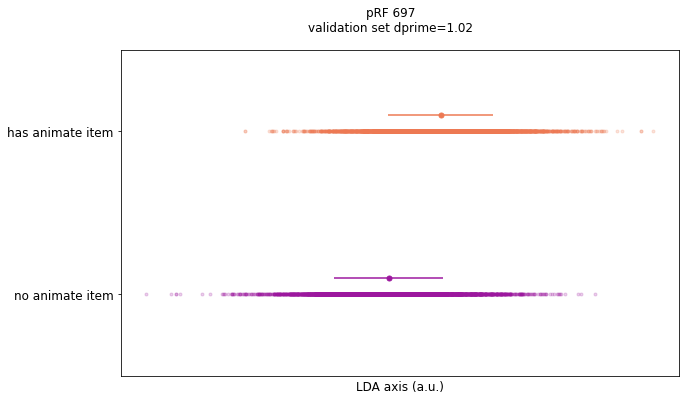

In [7]:

scores = scores_each_prf[prf_model_index][ims_to_use,:]

plot_utils.set_all_font_sizes(12)
plt.figure(figsize=(10,6));

colors = cm.plasma(np.linspace(0,1,4))
colors = colors[1:3,:]

lh=[]
uncats = np.unique(labels_actual)
for cc in range(n_categ):

    inds = labels_actual==uncats[cc]
    
    meanval = np.mean(scores[inds,:], axis=0)
#     semval = np.std(scores[inds,:], axis=0)/np.sqrt(np.sum(inds))
    semval = np.std(scores[inds,:], axis=0)
    plt.plot(scores[inds,0], np.ones((np.sum(inds),1))*uncats[cc],'.',alpha=0.2,color=colors[cc])
    
    plt.plot(meanval, uncats[cc]+0.1, '.', markersize=10, color = colors[cc])
    plt.errorbar(meanval, uncats[cc]+0.1, xerr=semval, yerr=None, color=colors[cc])
    
plt.xlabel('LDA axis (a.u.)')

plt.xticks([])
plt.yticks(uncats, ['no animate item','has animate item'])
plt.ylim([-0.5, 1.5])
# plt.suptitle('pRF %d'%(prf_model_index))
plt.suptitle('pRF %d\nvalidation set dprime=%.2f'%(prf_model_index, val_dprime_each_prf[prf_model_index]))

Text(0.5, 0.98, 'LDA scalings from sketch tokens model, all features\n')

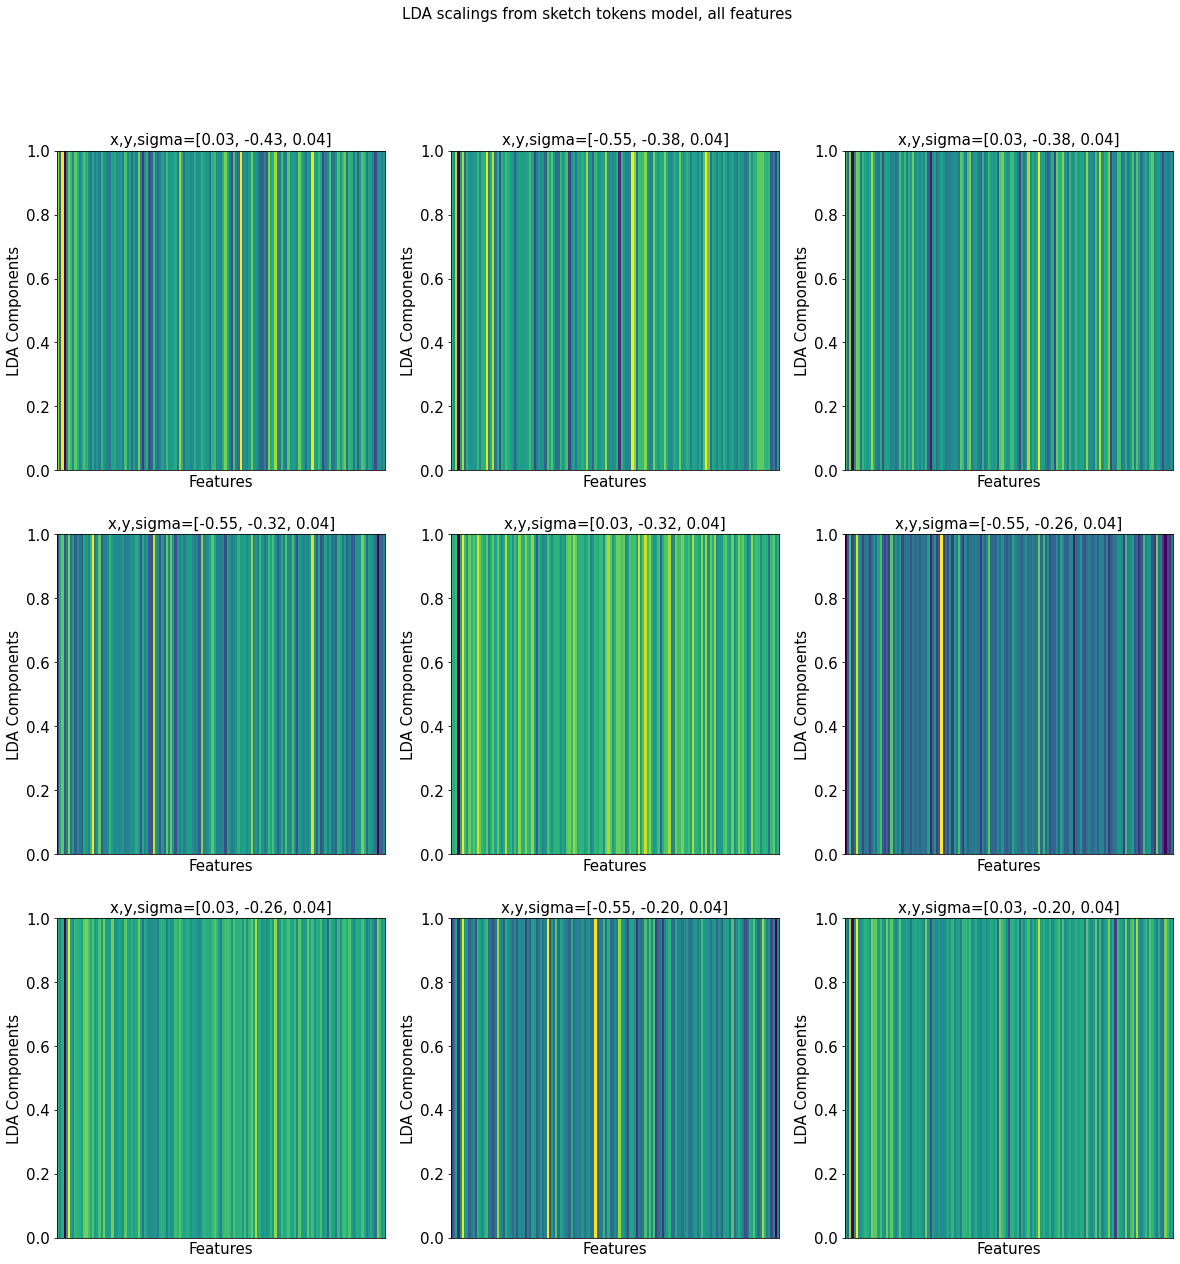

In [8]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(20,20));

# pcs2plot = [0,1]
# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))

mm2plot = np.arange(50,140,10)
npx = int(np.ceil(np.sqrt(len(mm2plot))))
npy = int(np.ceil(len(mm2plot)/npx))

for mi, mm in enumerate(mm2plot):
    wts = wts_each_prf[mm].T
    # wts is components x features
    plt.subplot(npx,npy,mi+1)
    
    plt.pcolormesh(wts)
    
#     if mi==len(mm2plot)-npx:
#         plt.xlabel('PC %d (a.u.)'%(pcs2plot[0]+1))
#         plt.ylabel('PC %d (a.u.)'%(pcs2plot[1]+1))
    
    plt.xticks([])
#     plt.yticks([])
    
    plt.ylabel('LDA Components')
    plt.xlabel('Features')
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    
plt.suptitle('LDA scalings from sketch tokens model, all features\n')
    

Text(0.5, 0.98, 'Comparing LDA scalings across models: colors are pRF models')

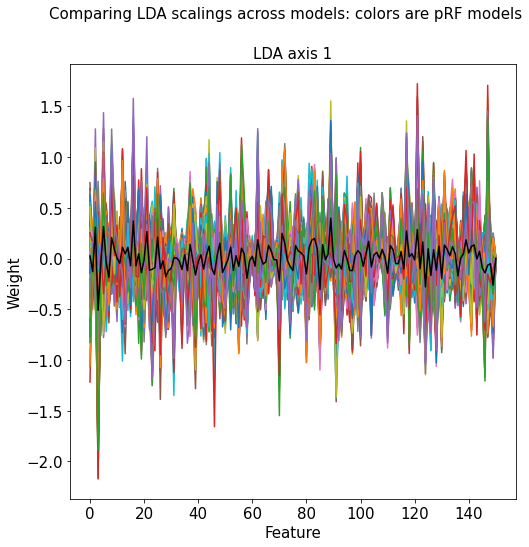

In [8]:
plt.figure(figsize=(8,8));

npx=3;npy=3

w2plot = np.array([wts_each_prf[mm][:,0] for mm in range(n_prfs)])
plt.plot(w2plot.T);
plt.title('LDA axis 1')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.plot(np.mean(w2plot, axis=0), color='k')
         
plt.suptitle('Comparing LDA scalings across models: colors are pRF models')

In [55]:
w2plot.shape

(875, 151)

In [11]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
clusters = clust['clusters']['clusters'][0][0]

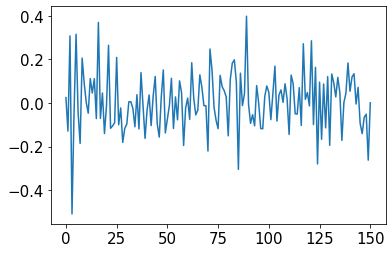

In [12]:
plt.figure();
pc=0

plt.plot(np.mean(w2plot, axis=0))

Text(0.5, 0.98, 'Sketch token features with lowest weights for LDA axis 0')

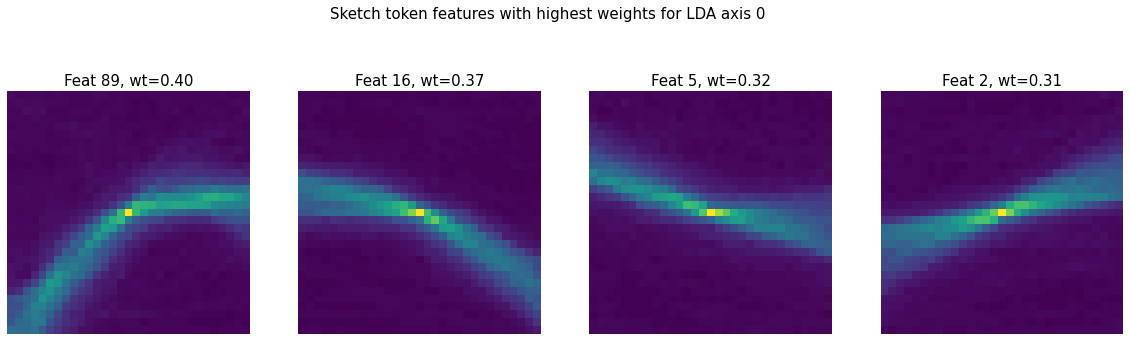

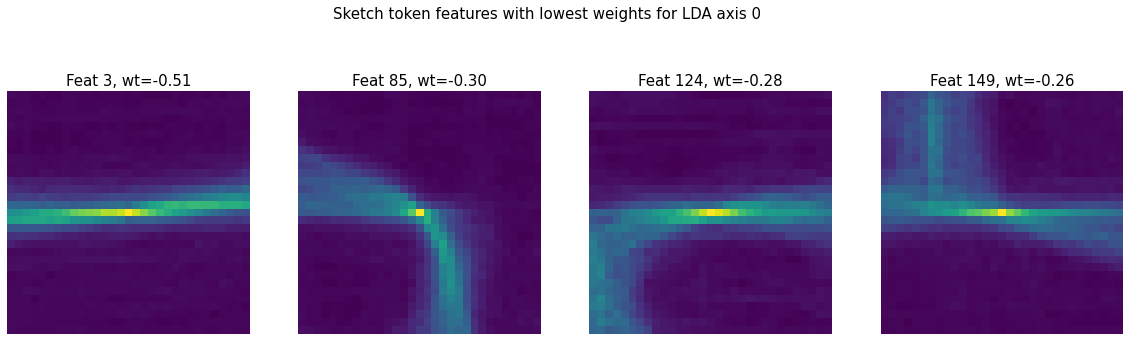

In [13]:
nclusters = clusters.shape[2]
n2plot = 4

w = np.mean(w2plot, axis=0)

clusters2plot = np.flip(np.argsort(w))[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with highest weights for LDA axis %d'%pc)

clusters2plot = np.argsort(w)[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with lowest weights for LDA axis %d'%pc)

Text(0.5, 0.98, 'Sketch token features with lowest weights for LDA axis 0')

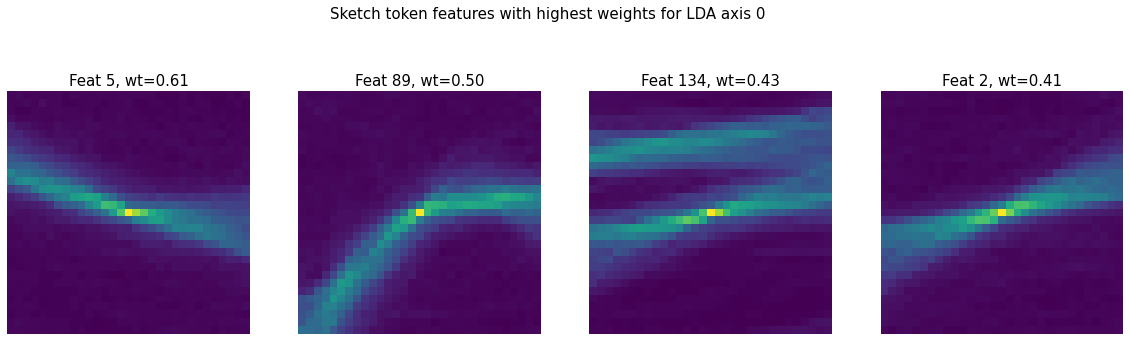

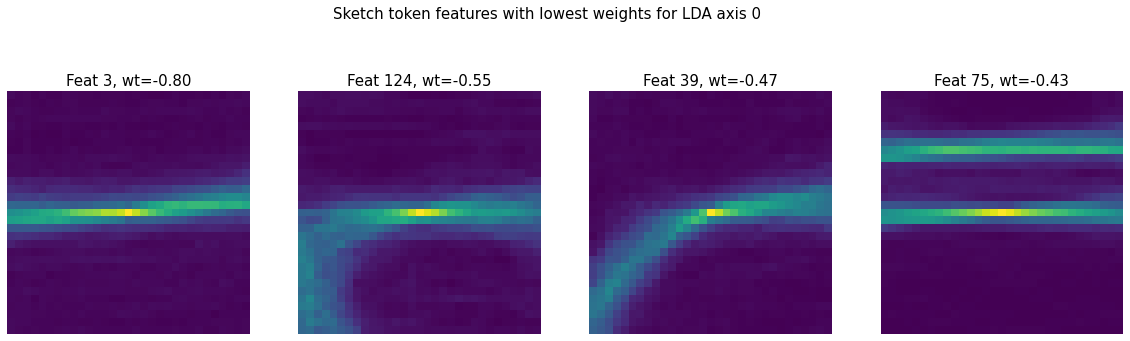

In [14]:
nclusters = clusters.shape[2]
n2plot = 4

# w = np.mean(w2plot, axis=0)
w = w2plot[mm,:]

clusters2plot = np.flip(np.argsort(w))[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with highest weights for LDA axis %d'%pc)

clusters2plot = np.argsort(w)[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with lowest weights for LDA axis %d'%pc)